<center><h1>Chen_Shufen_Final_Project</h1></center>
<br>
<br>

Name: Shufen Chen
<br>
Github Username: shufench-usc
<br>
USC ID: 9180940635

Package imports

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_METAL_LOG_LEVEL"] = "0"


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, utils, Sequential
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16, DenseNet201
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_pre_input
from tensorflow.keras.applications.resnet import preprocess_input as resnet101_pre_input
from tensorflow.keras.applications.efficientnet import preprocess_input  as effi_pre_input
from tensorflow.keras.applications.vgg16 import preprocess_input  as vgg_pre_input
from tensorflow.keras.applications.densenet import preprocess_input  as dense_pre_input
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd


In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## (b) Data Exploration and Pre-processing

### i & ii. One-hot encoding and resizing images

In [4]:
# get the training data, test data and validation data
train_data = utils.image_dataset_from_directory(
    "../data/Jute_Pest_Dataset/train",
    image_size=(224, 224),  # resize to the same size
    batch_size=5,  # bacth size = 5
    label_mode="categorical",  # one-hot encoding of labels
)
test_data = utils.image_dataset_from_directory(
    "../data/Jute_Pest_Dataset/test",
    image_size=(224, 224),
    batch_size=5,
    label_mode="categorical",
)
val_data = utils.image_dataset_from_directory(
    "../data/Jute_Pest_Dataset/val",
    image_size=(224, 224),
    batch_size=5,
    label_mode="categorical",
)

Found 6443 files belonging to 17 classes.
Found 379 files belonging to 17 classes.
Found 413 files belonging to 17 classes.


### (c) Transfer Learning

In [5]:
# image augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"), # randomly flip(horizontal)
    layers.RandomRotation(0.1),  # randomly rotate (10%)
    layers.RandomZoom(0.1), # randomly zoom (10%)
    layers.RandomContrast(0.1), # randomly change the constrast (10%)
    layers.RandomTranslation(0.1, 0.1), # randomly translate the images (10%-x, 10%-y)
])

In [6]:
# prepare the data pipeline
train_ds = (
    train_data
    .shuffle(1000) # shuttle the training data
    .prefetch(tf.data.AUTOTUNE) # use prefetch to improve the data processing efficiency
)

# testing data and validation data do not need to shuffle
val_ds = val_data.prefetch(tf.data.AUTOTUNE)
test_ds = test_data.prefetch(tf.data.AUTOTUNE)

# get the non-shuffle training data to evaluate the outcome
train_ds_noshuffle = train_data.prefetch(tf.data.AUTOTUNE)

# get the number and names of training data classes
num_classes = len(train_data.class_names)
class_names = train_data.class_names
print("Classes:", class_names)

Classes: ['Beet Armyworm', 'Black Hairy', 'Cutworm', 'Field Cricket', 'Jute Aphid', 'Jute Hairy', 'Jute Red Mite', 'Jute Semilooper', 'Jute Stem Girdler', 'Jute Stem Weevil', 'Leaf Beetle', 'Mealybug', 'Pod Borer', 'Scopula Emissaria', 'Termite', 'Termite odontotermes (Rambur)', 'Yellow Mite']


#### i. ResNet50

In [16]:
base_model = ResNet50(
    include_top=False, # remove the fully-connected layer at the top of the network
    weights="imagenet", # pre-trained wights
    input_shape=(224, 224, 3), # input image size and number of channels(RGB)
)

# freeze the convolutional base
base_model.trainable = False

# input layer
inputs = keras.Input(shape=(224, 224, 3))

# augmentation layer
x = data_augmentation(inputs)

# input process for ResNet50
x = resnet50_pre_input(x)

# extract features using the frozen ResNet50 base
x = base_model(x, training=False)

# global average pooling
x = layers.GlobalAveragePooling2D()(x)

# fully-connected layer
x = layers.Dense(
    256,
    activation="relu", # activation function
    kernel_regularizer=keras.regularizers.l2(1e-4) # l2 regularization
)(x)

# batch normalization
x = layers.BatchNormalization()(x)

# dropout 20% neurons as 0
x = layers.Dropout(0.2)(x)  

# output layer(softmax)
outputs = layers.Dense(
    num_classes,
    activation="softmax"
)(x)

# Build complete model
resnet50_model = keras.Model(inputs, outputs)

# Compile model
resnet50_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy", # multi-class classification  
    metrics=["accuracy"] # tracking the training accuracy
)

# get the model details
resnet50_model.summary()

# early stopping using validation loss
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10, # number of epochs with no improvement before stopping           
    restore_best_weights=True # store the best wight
)

# train the model, epochs = 100
initial_epochs = 100  
history = resnet50_model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

2025-12-14 23:50:23.322318: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


1289/1289 [==============================] - 187s 128ms/step - loss: 1.2238 - accuracy: 0.6509 - val_loss: 0.6380 - val_accuracy: 0.8378
Epoch 2/100
1289/1289 [==============================] - 164s 115ms/step - loss: 0.5323 - accuracy: 0.8636 - val_loss: 0.5308 - val_accuracy: 0.8862
Epoch 3/100
1289/1289 [==============================] - 153s 110ms/step - loss: 0.4055 - accuracy: 0.8949 - val_loss: 0.5116 - val_accuracy: 0.8741
Epoch 4/100
1289/1289 [==============================] - 157s 113ms/step - loss: 0.3298 - accuracy: 0.9201 - val_loss: 0.4956 - val_accuracy: 0.8935
Epoch 5/100
1289/1289 [==============================] - 153s 113ms/step - loss: 0.2828 - accuracy: 0.9320 - val_loss: 0.5082 - val_accuracy: 0.8838
Epoch 6/100
1289/1289 [==============================] - 146s 108ms/step - loss: 0.2471 - accuracy: 0.9437 - val_loss: 0.5137 - val_accuracy: 0.8983
Epoch 7/100
1289/1289 [==============================] - 146s 108ms/step - loss: 0.2229 - accuracy: 0.9516 - val_loss:

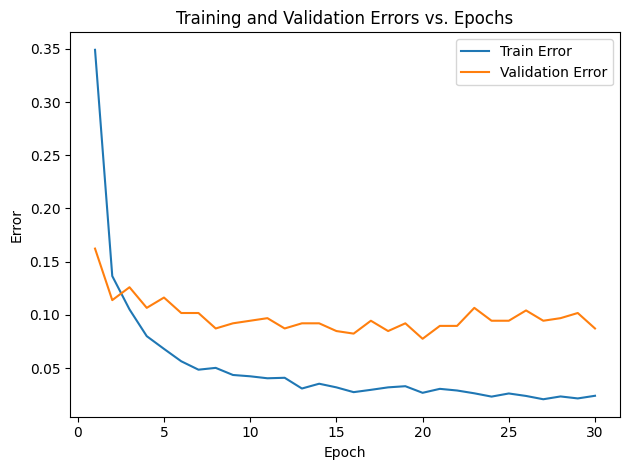

In [17]:
# plot the training and validation errors vs. epochs
train_acc = np.array(history.history["accuracy"])
val_acc = np.array(history.history["val_accuracy"])

train_err = 1.0 - train_acc
val_err = 1.0 - val_acc
epochs_range = range(1, len(train_err) + 1)

plt.figure()
plt.plot(epochs_range, train_err, label="Train Error")
plt.plot(epochs_range, val_err, label="Validation Error")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training and Validation Errors vs. Epochs")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
def evaluate_metrics_on_dataset(name, dataset, model):
    """
    This function is used ro evaluate the performance metrics of training set, test set, and validation

    Parameters:
    name: name of data set
    dataset: the dataset needs to be evaluated
    model: network model

    Returns:
    None: prints out the metrics dataframe
    """

    # create empty lists to store the ture y and the probability of predicted y
    y_true_list = []
    y_prob_list = []

    # iterate through the dataset batch by batch
    for batch_x, batch_y in dataset:
        probs = model.predict(batch_x, verbose=0)
        y_prob_list.append(probs)
        y_true_list.append(batch_y.numpy())

    # connect all the predicted probabilities into array
    y_prob = np.concatenate(y_prob_list, axis=0)         
    y_true_onehot = np.concatenate(y_true_list, axis=0)  

    # convert one-hot labels and predicted probabilities into classes
    y_true = np.argmax(y_true_onehot, axis=1)           
    y_pred = np.argmax(y_prob, axis=1)                  

    # calculate the precision, recall, f1 and auc
    precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    auc = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")

    res_df = pd.DataFrame({"Precision": [precision], "Recall": [recall], "F1": [f1], "AUC": [auc]})

    print(f"\n{name} metrics:")
    display(res_df)



In [19]:
evaluate_metrics_on_dataset("Train", train_ds_noshuffle, resnet50_model)
evaluate_metrics_on_dataset("Validation", val_ds, resnet50_model)
evaluate_metrics_on_dataset("Test", test_ds, resnet50_model)


Train metrics:


,Precision,Recall,F1,AUC
0,0.99614,0.997157,0.996636,0.999991



Validation metrics:


,Precision,Recall,F1,AUC
0,0.90267,0.849537,0.864495,0.988629



Test metrics:


,Precision,Recall,F1,AUC
0,0.988759,0.988866,0.988689,0.999893


#### ii. ResNet101

In [21]:
# build the ResNet101 base model without the top classifier
base_model = ResNet101(
    include_top=False,               # remove the fully-connected layer at the top of the network
    weights="imagenet",              # pre-trained weights
    input_shape=(224, 224, 3),       # input image size and number of channels (RGB)
)

# freeze the convolutional base
base_model.trainable = False

# input layer
inputs = keras.Input(shape=(224, 224, 3))

# augmentation layer
x = data_augmentation(inputs)

# input process for ResNet101
x = resnet101_pre_input(x)

# extract features using the frozen ResNet101 base
x = base_model(x, training=False)

# global average pooling
x = layers.GlobalAveragePooling2D()(x)

# fully-connected layer
x = layers.Dense(
    256,
    activation="relu",                              # activation function
    kernel_regularizer=keras.regularizers.l2(1e-4)  # l2 regularization
)(x)

# batch normalization
x = layers.BatchNormalization()(x)

# dropout 20% neurons as 0
x = layers.Dropout(0.2)(x)

# output layer (softmax)
outputs = layers.Dense(
    num_classes,
    activation="softmax"
)(x)

# Build complete model
resnet101_model = keras.Model(inputs, outputs)

# Compile model
resnet101_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",   # multi-class classification
    metrics=["accuracy"]               # tracking the training accuracy
)

# get the model details
resnet101_model.summary()

# train the model, epochs = initial_epochs
history_101 = resnet101_model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0   

2025-12-15 01:08:29.886525: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


1289/1289 [==============================] - 207s 148ms/step - loss: 1.1989 - accuracy: 0.6598 - val_loss: 0.5937 - val_accuracy: 0.8305
Epoch 2/100
1289/1289 [==============================] - 196s 146ms/step - loss: 0.5118 - accuracy: 0.8671 - val_loss: 0.4865 - val_accuracy: 0.8717
Epoch 3/100
1289/1289 [==============================] - 202s 150ms/step - loss: 0.3896 - accuracy: 0.9019 - val_loss: 0.4724 - val_accuracy: 0.8741
Epoch 4/100
1289/1289 [==============================] - 198s 148ms/step - loss: 0.3146 - accuracy: 0.9266 - val_loss: 0.4605 - val_accuracy: 0.8838
Epoch 5/100
1289/1289 [==============================] - 225s 169ms/step - loss: 0.2713 - accuracy: 0.9364 - val_loss: 0.4571 - val_accuracy: 0.8910
Epoch 6/100
1289/1289 [==============================] - 203s 152ms/step - loss: 0.2370 - accuracy: 0.9458 - val_loss: 0.4302 - val_accuracy: 0.9128
Epoch 7/100
1289/1289 [==============================] - 201s 150ms/step - loss: 0.2296 - accuracy: 0.9497 - val_loss:

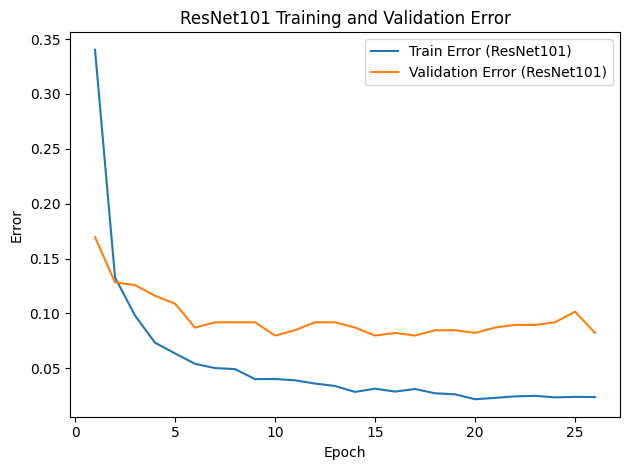

In [22]:
train_acc_101 = np.array(history_101.history["accuracy"])
val_acc_101 = np.array(history_101.history["val_accuracy"])

train_err_101 = 1.0 - train_acc_101
val_err_101 = 1.0 - val_acc_101
epochs_range_101 = range(1, len(train_err_101) + 1)

plt.figure()
plt.plot(epochs_range_101, train_err_101, label="Train Error (ResNet101)")
plt.plot(epochs_range_101, val_err_101, label="Validation Error (ResNet101)")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("ResNet101 Training and Validation Error")
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
evaluate_metrics_on_dataset("Train (ResNet101)", train_ds_noshuffle, resnet101_model)
evaluate_metrics_on_dataset("Validation (ResNet101)", val_ds, resnet101_model)
evaluate_metrics_on_dataset("Test (ResNet101)", test_ds, resnet101_model)


Train (ResNet101) metrics:


,Precision,Recall,F1,AUC
0,0.992531,0.992562,0.992517,0.999979



Validation (ResNet101) metrics:


,Precision,Recall,F1,AUC
0,0.875929,0.881829,0.872626,0.992385



Test (ResNet101) metrics:


,Precision,Recall,F1,AUC
0,0.981539,0.980882,0.980425,0.999905


#### iii. EfficientNetB0

In [10]:

initial_epochs = 100 
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10, # number of epochs with no improvement before stopping           
    restore_best_weights=True # store the best wight
)

In [ ]:
# build the EfficientNetB0 base model without the top classifier
base_model = EfficientNetB0(
    include_top=False,               # remove the fully-connected layer at the top of the network
    weights="imagenet",              # pre-trained weights
    input_shape=(224, 224, 3),       # input image size and number of channels (RGB)
)

# freeze the convolutional base
base_model.trainable = False

# input layer
inputs = keras.Input(shape=(224, 224, 3))

# augmentation layer
x = data_augmentation(inputs)

# input process for EfficientNetB0
x = effi_pre_input(x)

# extract features using the frozen EfficientNetB0 base
x = base_model(x, training=False)

# global average pooling
x = layers.GlobalAveragePooling2D()(x)

# fully-connected layer
x = layers.Dense(
    256,
    activation="relu",                              # activation function
    kernel_regularizer=keras.regularizers.l2(1e-4)  # l2 regularization
)(x)

# batch normalization
x = layers.BatchNormalization()(x)

# dropout 20% neurons as 0
x = layers.Dropout(0.2)(x)

# output layer (softmax)
outputs = layers.Dense(
    num_classes,
    activation="softmax"
)(x)

# Build complete model
efficientnetb0_model = keras.Model(inputs, outputs)

# Compile model
efficientnetb0_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",   # multi-class classification
    metrics=["accuracy"]               # tracking the training accuracy
)

# get the model details
efficientnetb0_model.summary()

# train the model, epochs = initial_epochs
history_b0 = efficientnetb0_model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                           

2025-12-15 08:40:38.008160: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


 630/1289 [=============>................] - ETA: 1:13 - loss: 1.6556 - accuracy: 0.5289

2025-12-15 08:42:14.808 python[37149:19225791] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-37149-2025-12-15_08_42_14-576873868‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.


1289/1289 [==============================] - 170s 108ms/step - loss: 1.2269 - accuracy: 0.6544 - val_loss: 0.5956 - val_accuracy: 0.8426
Epoch 2/100
  63/1289 [>.............................] - ETA: 9:04 - loss: 0.6678 - accuracy: 0.8222

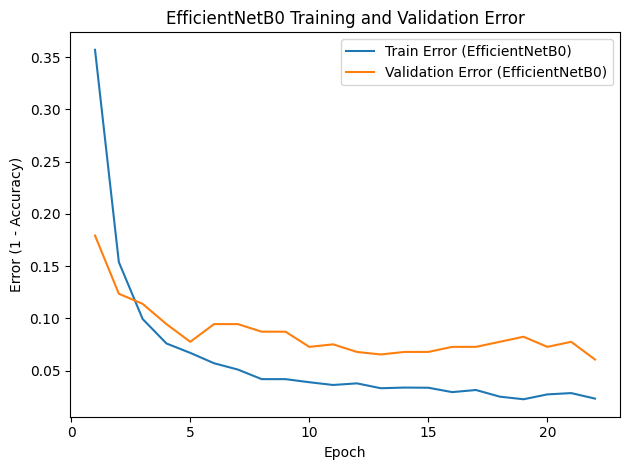

In [ ]:

train_acc_eff = np.array(history_b0.history["accuracy"])
val_acc_eff = np.array(history_b0.history["val_accuracy"])

train_err_eff = 1.0 - train_acc_eff
val_err_eff = 1.0 - val_acc_eff
epochs_range_eff = range(1, len(train_err_eff) + 1)

plt.figure()
plt.plot(epochs_range_eff, train_err_eff, label="Train Error (EfficientNetB0)")
plt.plot(epochs_range_eff, val_err_eff, label="Validation Error (EfficientNetB0)")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("EfficientNetB0 Training and Validation Error")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
evaluate_metrics_on_dataset("Train (EfficientNetB0)", train_ds_noshuffle, efficientnetb0_model)
evaluate_metrics_on_dataset("Validation (EfficientNetB0)", val_ds, efficientnetb0_model)
evaluate_metrics_on_dataset("Test (EfficientNetB0)", test_ds, efficientnetb0_model)

2025-12-10 20:31:30.578883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Train (EfficientNetB0) metrics:


,Precision,Recall,F1,AUC
0,0.990099,0.990414,0.990184,0.999946



Validation (EfficientNetB0) metrics:


,Precision,Recall,F1,AUC
0,0.87974,0.894782,0.88448,0.994557



Test (EfficientNetB0) metrics:


,Precision,Recall,F1,AUC
0,0.97927,0.978922,0.978101,0.999947


#### iv. VGG16

In [ ]:
# build the VGG16 base model without the top classifier
base_model = VGG16(
    include_top=False,               # remove the fully-connected layer at the top of the network
    weights="imagenet",              # pre-trained weights
    input_shape=(224, 224, 3),       # input image size and number of channels (RGB)
)

# freeze the convolutional base
base_model.trainable = False

# input layer
inputs = keras.Input(shape=(224, 224, 3))

# augmentation layer
x = data_augmentation(inputs)

# input process for VGG16
x = vgg_pre_input(x)

# extract features using the frozen VGG16 base
x = base_model(x, training=False)

# global average pooling
x = layers.GlobalAveragePooling2D()(x)

# fully-connected layer
x = layers.Dense(
    256,
    activation="relu",                              # activation function
    kernel_regularizer=keras.regularizers.l2(1e-4)  # l2 regularization
)(x)

# batch normalization
x = layers.BatchNormalization()(x)

# dropout 20% neurons as 0
x = layers.Dropout(0.2)(x)

# output layer (softmax)
outputs = layers.Dense(
    num_classes,
    activation="softmax"
)(x)

# Build complete model
vgg16_model = keras.Model(inputs, outputs)

# Compile model
vgg16_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",   # multi-class classification
    metrics=["accuracy"]               # tracking the training accuracy
)

# get the model details
vgg16_model.summary()

# train the model, epochs = initial_epochs
history_vgg16 = vgg16_model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16_jute_pest"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input_vgg (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                    

2025-12-11 00:46:41.193556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-12-11 00:46:41.470561: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


1289/1289 [==============================] - ETA: 0s - loss: 1.9787 - accuracy: 0.4262

2025-12-11 00:49:29.068037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1289/1289 [==============================] - 177s 128ms/step - loss: 1.9787 - accuracy: 0.4262 - val_loss: 0.9840 - val_accuracy: 0.7191
Epoch 2/100
1289/1289 [==============================] - 173s 131ms/step - loss: 1.0668 - accuracy: 0.6904 - val_loss: 0.7984 - val_accuracy: 0.7821
Epoch 3/100
1289/1289 [==============================] - 178s 134ms/step - loss: 0.8501 - accuracy: 0.7574 - val_loss: 0.6799 - val_accuracy: 0.8232
Epoch 4/100
1289/1289 [==============================] - 180s 136ms/step - loss: 0.7127 - accuracy: 0.7982 - val_loss: 0.6596 - val_accuracy: 0.8378
Epoch 5/100
1289/1289 [==============================] - 189s 144ms/step - loss: 0.6257 - accuracy: 0.8226 - val_loss: 0.6310 - val_accuracy: 0.8450
Epoch 6/100
1289/1289 [==============================] - 186s 140ms/step - loss: 0.5789 - accuracy: 0.8373 - val_loss: 0.5854 - val_accuracy: 0.8668
Epoch 7/100
1289/1289 [==============================] - 191s 144ms/step - loss: 0.5320 - accuracy: 0.8541 - val_loss:

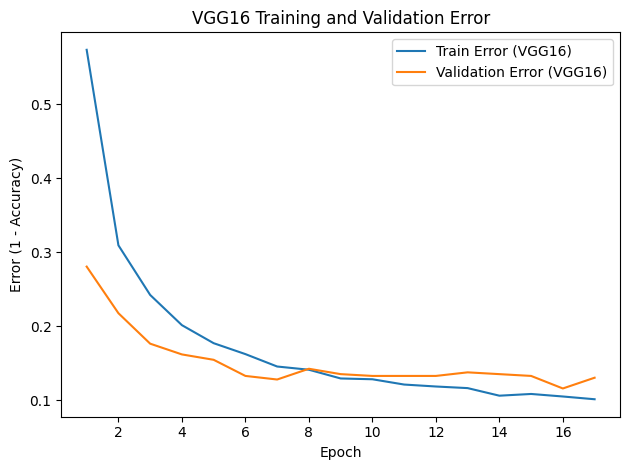

In [ ]:
train_acc_vgg = np.array(history_vgg16.history["accuracy"])
val_acc_vgg = np.array(history_vgg16.history["val_accuracy"])

train_err_vgg = 1.0 - train_acc_vgg
val_err_vgg = 1.0 - val_acc_vgg
epochs_range_vgg = range(1, len(train_err_vgg) + 1)

plt.figure()
plt.plot(epochs_range_vgg, train_err_vgg, label="Train Error (VGG16)")
plt.plot(epochs_range_vgg, val_err_vgg, label="Validation Error (VGG16)")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("VGG16 Training and Validation Error")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
evaluate_metrics_on_dataset("Train (VGG16)", train_ds_noshuffle, vgg16_model)
evaluate_metrics_on_dataset("Validation (VGG16)", val_ds, vgg16_model)
evaluate_metrics_on_dataset("Test (VGG16)", test_ds, vgg16_model)

2025-12-11 01:39:46.030430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Train (VGG16) metrics:


,Precision,Recall,F1,AUC
0,0.947665,0.945018,0.945624,0.99794



Validation (VGG16) metrics:


,Precision,Recall,F1,AUC
0,0.815674,0.834845,0.818717,0.959281



Test (VGG16) metrics:


,Precision,Recall,F1,AUC
0,0.948158,0.943182,0.943226,0.9986


#### v. DenseNet201

In [ ]:
# build the DenseNet201 base model without the top classifier
base_model = DenseNet201(
    include_top=False,               # remove the fully-connected layer at the top of the network
    weights="imagenet",              # pre-trained weights
    input_shape=(224, 224, 3),       # input image size and number of channels (RGB)
)

# freeze the convolutional base
base_model.trainable = False

# input layer
inputs = keras.Input(shape=(224, 224, 3))

# augmentation layer
x = data_augmentation(inputs)

# input process for DenseNet201
x = dense_pre_input(x)

# extract features using the frozen DenseNet201 base
x = base_model(x, training=False)

# global average pooling
x = layers.GlobalAveragePooling2D()(x)

# fully-connected layer
x = layers.Dense(
    256,
    activation="relu",                              # activation function
    kernel_regularizer=keras.regularizers.l2(1e-4)  # l2 regularization
)(x)

# batch normalization
x = layers.BatchNormalization()(x)

# dropout 20% neurons as 0
x = layers.Dropout(0.2)(x)

# output layer (softmax)
outputs = layers.Dense(
    num_classes,
    activation="softmax"
)(x)

# Build complete model
densenet201_model = keras.Model(inputs, outputs)

# Compile model
densenet201_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",   # multi-class classification
    metrics=["accuracy"]               # tracking the training accuracy
)

# get the model details
densenet201_model.summary()

# train the model, epochs = initial_epochs
history_densenet201 = densenet201_model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

74836368/74836368 [==============================] - 2s 0us/step
Model: "densenet201_jute_pest"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input_densenet201 (In  [(None, 224, 224, 3)]    0         
 putLayer)                                                       
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                              

2025-12-11 01:43:12.372416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-12-11 01:43:13.076429: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


1289/1289 [==============================] - ETA: 0s - loss: 1.4114 - accuracy: 0.5920

2025-12-11 01:48:03.561347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1289/1289 [==============================] - 317s 230ms/step - loss: 1.4114 - accuracy: 0.5920 - val_loss: 0.5878 - val_accuracy: 0.8208
Epoch 2/100
1289/1289 [==============================] - 346s 258ms/step - loss: 0.6003 - accuracy: 0.8344 - val_loss: 0.4758 - val_accuracy: 0.8668
Epoch 3/100
1289/1289 [==============================] - 358s 268ms/step - loss: 0.4262 - accuracy: 0.8825 - val_loss: 0.4299 - val_accuracy: 0.8910
Epoch 4/100
1289/1289 [==============================] - 348s 258ms/step - loss: 0.3401 - accuracy: 0.9089 - val_loss: 0.4667 - val_accuracy: 0.8862
Epoch 5/100
1289/1289 [==============================] - 347s 255ms/step - loss: 0.2976 - accuracy: 0.9215 - val_loss: 0.3738 - val_accuracy: 0.9007
Epoch 6/100
1289/1289 [==============================] - 352s 258ms/step - loss: 0.2547 - accuracy: 0.9309 - val_loss: 0.4168 - val_accuracy: 0.8910
Epoch 7/100
1289/1289 [==============================] - 344s 258ms/step - loss: 0.2372 - accuracy: 0.9379 - val_loss:

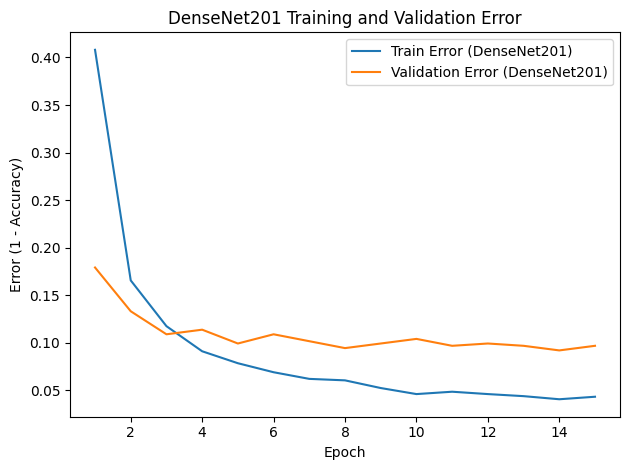

In [ ]:
train_acc_dense = np.array(history_densenet201.history["accuracy"])
val_acc_dense = np.array(history_densenet201.history["val_accuracy"])

train_err_dense = 1.0 - train_acc_dense
val_err_dense = 1.0 - val_acc_dense
epochs_range_dense = range(1, len(train_err_dense) + 1)

plt.figure()
plt.plot(epochs_range_dense, train_err_dense, label="Train Error (DenseNet201)")
plt.plot(epochs_range_dense, val_err_dense, label="Validation Error (DenseNet201)")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("DenseNet201 Training and Validation Error")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
evaluate_metrics_on_dataset("Train (DenseNet201)", train_ds_noshuffle, densenet201_model)
evaluate_metrics_on_dataset("Validation (DenseNet201)", val_ds, densenet201_model)
evaluate_metrics_on_dataset("Test (DenseNet201)", test_ds, densenet201_model)

2025-12-11 03:12:20.158331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Train (DenseNet201) metrics:


,Precision,Recall,F1,AUC
0,0.974919,0.976942,0.975428,0.999728



Validation (DenseNet201) metrics:


,Precision,Recall,F1,AUC
0,0.844566,0.849222,0.842038,0.990518



Test (DenseNet201) metrics:


,Precision,Recall,F1,AUC
0,0.975524,0.97402,0.973784,0.999214


## Reference

1. Transfer learning and fine-tuning: https://www.tensorflow.org/tutorials/images/transfer_learning
2. https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb?hl=zh-cn#scrollTo=nnrWf3PCEzXL
3. image data loading by keras: https://keras.io/2/api/data_loading/image/
4. image augmentation: https://www.tensorflow.org/tutorials/images/data_augmentation
5. pipeline: https://www.tensorflow.org/guide/data,  https://www.tensorflow.org/guide/data_performance
6. ResNet: https://keras.io/api/applications/resnet/#resnet50-function